In [38]:
import pandas as pd
from ast import literal_eval
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.manifold import TSNE
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import normalize

## 1. Load the Data

In [2]:
df = pd.read_csv("final_data_complete.csv")

In [3]:
df = df.drop(columns = ["FreebaseID", "Genres_tuples", "Languages_tuple", "Countries_tuples", "ActorGenderFlag", "movieId", "ActorGender", "merge_year"])
assert df["distilbert_emotions"].isna().sum() == df["Plot"].isna().sum()
df = df.dropna(subset = ["distilbert_emotions"])
df["distilbert_emotions"] = df["distilbert_emotions"].apply(literal_eval)


In [4]:
print (df["distilbert_emotions"][0].keys())

df["disgust"] = df["distilbert_emotions"].apply(lambda x: x["disgust"])
df["fear"] = df["distilbert_emotions"].apply(lambda x: x["fear"])
df["anger"] = df["distilbert_emotions"].apply(lambda x: x["anger"])
df["neutral"] = df["distilbert_emotions"].apply(lambda x: x["neutral"])
df["sadness"] = df["distilbert_emotions"].apply(lambda x: x["sadness"])
df["surprise"] = df["distilbert_emotions"].apply(lambda x: x["surprise"])
df["joy"] = df["distilbert_emotions"].apply(lambda x: x["joy"])
df_emotions = df[["disgust","fear","anger","neutral","sadness", "surprise","joy" ]]
#df_emotions = df_emotions.reset_index(drop=True)
print(df_emotions.head())

dict_keys(['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'])
     disgust      fear     anger   neutral   sadness  surprise       joy
0   0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766
3   0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907
4   0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024
12  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421
13  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072


# 2. Understand the data

## 2.1 Data distributions: Standardized vs. Unstandardized

In [5]:
df_emotions.describe()

,disgust,fear,anger,neutral,sadness,surprise,joy
count,33684.000000,33684.000000,33684.000000,33684.000000,33684.000000,33684.000000,33684.000000
mean,0.177764,0.149237,0.198539,0.219286,0.162752,0.046947,0.045474
std,0.214311,0.234104,0.229028,0.222535,0.233720,0.117281,0.123427
min,0.000178,0.000261,0.000586,0.000273,0.000860,0.000331,0.000223
25%,0.028759,0.008766,0.025399,0.051294,0.017766,0.004817,0.002622
50%,0.089153,0.033777,0.098616,0.131612,0.050893,0.010622,0.005704
75%,0.240457,0.177506,0.305622,0.321224,0.201197,0.029210,0.020456
max,0.987099,0.994397,0.990883,0.966400,0.988606,0.982970,0.983576


While emotions scores are on the same range they are on different scales -> standardize

In [6]:
standardizer = StandardScaler()
x_standardized = standardizer.fit_transform(df_emotions)
df_emotions_standardized= pd.DataFrame(x_standardized, columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy" ])

Text(0.5, 1.0, 'Standardized')

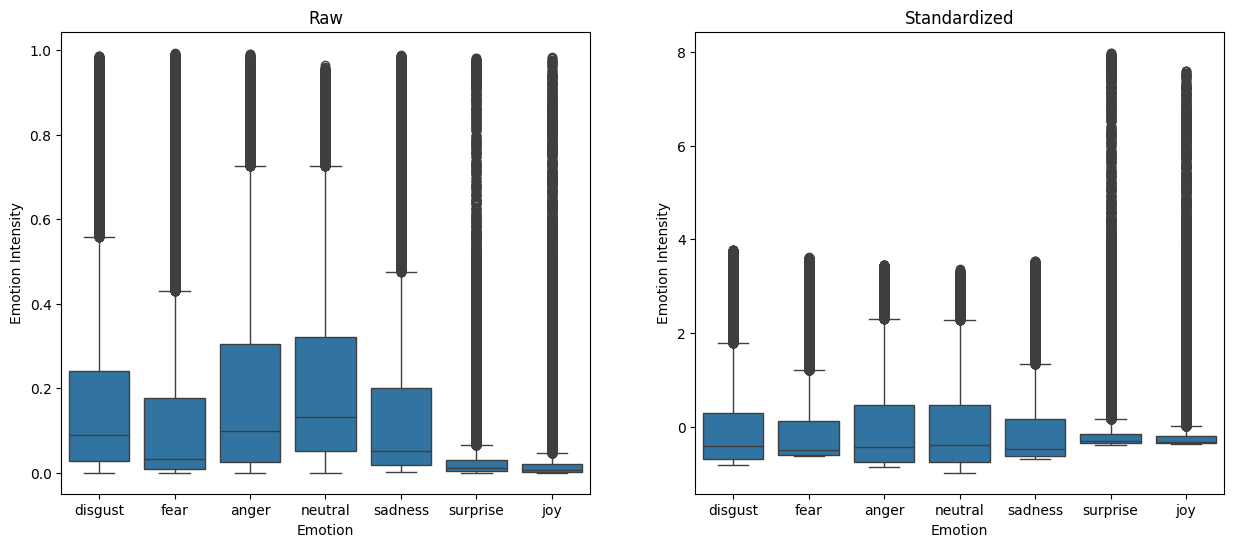

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6)) 
long_emotions = pd.melt(df_emotions, var_name='Emotion', value_name='Emotion Intensity')
long_emotions_standardized = pd.melt(df_emotions_standardized , var_name='Emotion', value_name='Emotion Intensity')
ax1= sns.boxplot(x="Emotion", y="Emotion Intensity", ax=axes[0], data=long_emotions)
ax1.set_title("Raw")
ax2 = sns.boxplot(x="Emotion", y="Emotion Intensity", ax=axes[1],data=long_emotions_standardized)
ax2.set_title("Standardized")

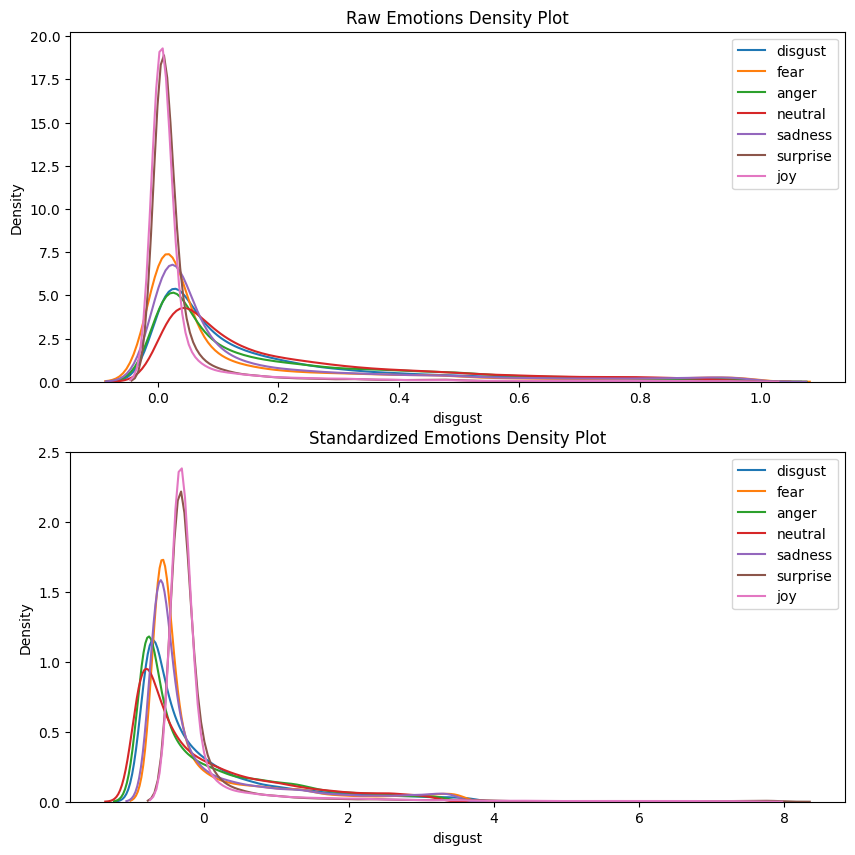

In [8]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10)) 
axes = axes.flatten()
for emotion in df_emotions.columns:
    ax1 = sns.kdeplot(data=df_emotions, x=emotion, ax=axes[0], label=emotion )
    ax1.set_title('Raw Emotions Density Plot')
    ax1.legend()
for emotion in df_emotions_standardized.columns:
    ax2 = sns.kdeplot(data=df_emotions_standardized, x=emotion, ax=axes[1], label=emotion )
    ax2.set_title('Standardized Emotions Density Plot')
    ax2.legend()

### Analysis with dimensionality reduction

### PCA
Measures linear relationship between data points. PCA leverages correlation between dimensions to retain as much variance as possible while projecting the features to a lower dimensional space.

In [9]:
pca = PCA(n_components=7)
pca.fit(x_standardized)


explained_variance_ratio = pca.explained_variance_ratio_
total_variance = sum(pca.explained_variance_ratio_)
print (total_variance)
print("Explained Variance Ratio per Principal Component: ", (explained_variance_ratio/total_variance) )

1.0
Explained Variance Ratio per Principal Component:  [2.19617464e-01 1.84789777e-01 1.74245101e-01 1.51494522e-01
 1.40970763e-01 1.28882372e-01 1.28609782e-15]


The results shows that all 7 principal components show significant variance, which is a sign for less correlation between dimensions. The visualization in 2d with the first two principal component only captures about 40% of the variance and therefore, might not be suitable for meassuring the clustering quality.

### t-nse
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear technique for dimensionality reduction. Instead of capturing variance  t-SNE focuses on preserving the local structure of the data

### Compute Correlation

No high correlation between the emotions. Highest correlation value is about negative 0.3 between neutral and anger)

In [10]:
correlation_matrix = df_emotions_standardized.corr()
print(correlation_matrix)

           disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.222989 -0.054629 -0.222855 -0.239088 -0.186218 -0.180542
fear     -0.222989  1.000000 -0.199830 -0.272488 -0.226751 -0.055683 -0.165145
anger    -0.054629 -0.199830  1.000000 -0.297105 -0.260816 -0.154437 -0.205403
neutral  -0.222855 -0.272488 -0.297105  1.000000 -0.219383 -0.028890  0.094986
sadness  -0.239088 -0.226751 -0.260816 -0.219383  1.000000 -0.091668 -0.081771
surprise -0.186218 -0.055683 -0.154437 -0.028890 -0.091668  1.000000 -0.009015
joy      -0.180542 -0.165145 -0.205403  0.094986 -0.081771 -0.009015  1.000000


### 2.2. Conclusion

Skwed data distributions

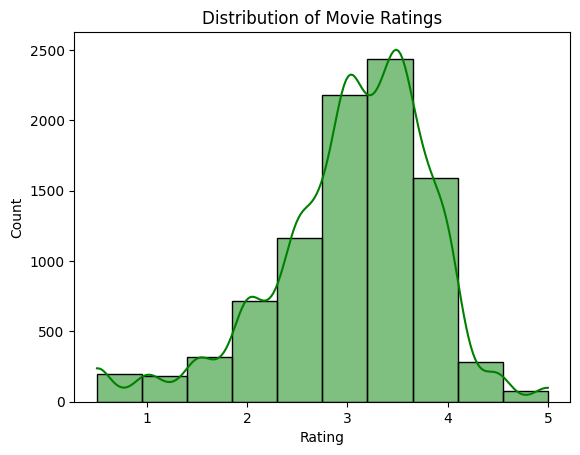

count    9139.000000
mean        3.044481
std         0.801812
min         0.500000
25%         2.625000
50%         3.152778
75%         3.571429
max         5.000000
Name: mean_ratings, dtype: float64


In [70]:
df_ratings = df_emotions.drop(columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"] )
df_ratings["mean_ratings"] = df.loc[df_emotions.index,"mean_ratings"]


sns.histplot(df['mean_ratings'], bins=10, kde=True, color='green')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print(df_ratings["mean_ratings"].describe())

# 3. Clustering

## 3.1 K-Means Clustering

### 3.1.1 Finding the optimal number of clusters k

Text(0, 0.5, 'Silhouette score')

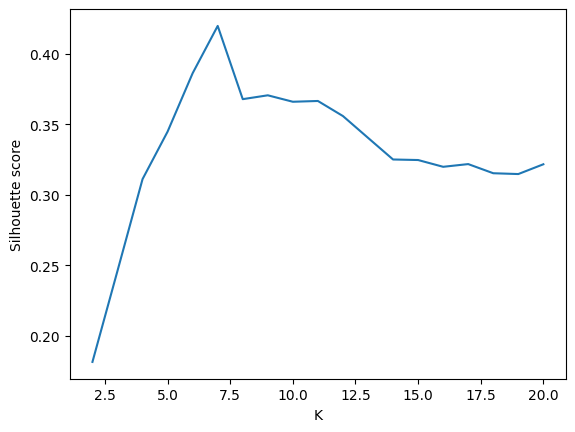

In [11]:
silhouettes = []

# Try multiple k
for k in range(2, 21):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(df_emotions_standardized)
    # Get the Silhouette score
    score = silhouette_score(df_emotions_standardized, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

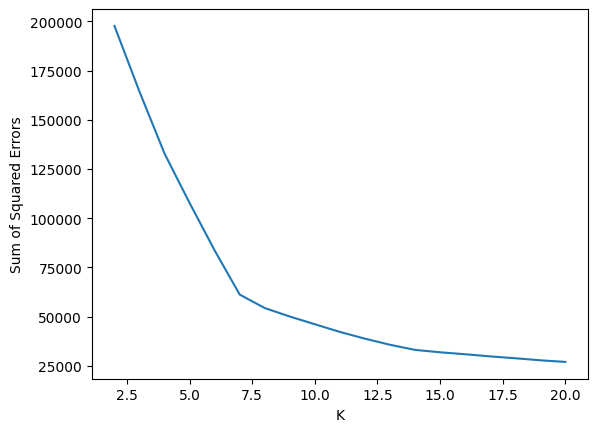

In [12]:
def plot_sse(df_emotions_standardized, start=2, end=21):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(df_emotions_standardized)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(df_emotions_standardized)

In [13]:
optimal_k = 7

### 3.1.2 Different cluster initializations to escape local optimums

The objective function of K-Means is to minimizing the within-cluster sum of squares (inertia). This is the metric it tries to minimize at each iteration. Therefore, initialization methods like k-means++' with n_init uses inertia to select the best initialization. We also loop over different random states and compare teh results to find the initialization with the lowest inertia

In [22]:
def find_best_initi_random_state(X):
    best_inertia = np.inf
    best_sil_score = -1
    best_random_state = None
    best_labels = None
    
    
    for rs in range(50):
        km = KMeans(n_clusters=optimal_k, init='k-means++', random_state=rs, n_init=1)
        km.fit(X)
        labels = km.labels_
        inertia = km.inertia_
        sil = silhouette_score(X, labels)
    
        # Use a combination of metrics or prioritize one. 
        # Often, inertia is primary for KMeans initialization selection, 
        # but silhouette can also be considered.
        # Let's say we pick the run with the best (lowest) inertia, and if tie, best silhouette.
        if (inertia < best_inertia) or (inertia == best_inertia and sil > best_sil_score):
            best_inertia = inertia
            best_sil_score = sil
            best_random_state = rs
            best_labels = labels
    
    print("Best run found with random_state:", best_random_state)
    print("Best inertia:", best_inertia)
    print("Best silhouette score:", best_sil_score)

    return km

find_best_initi(df_emotions_standardized)

Best run found with random_state: 31
Best inertia: 61240.475702318196
Best silhouette score: 0.41985879945898247


In [24]:
# Let KMeans do multiple initializations and pick the best
def find_best_init(X):
    km = KMeans(
        n_clusters=optimal_k, 
        init='k-means++', 
        n_init=1000,      # number of initial centroid sets
        random_state=42 # ensures reproducibility
    )
    km.fit(X)
    
    # The best run is now stored in km. 
    # You have reproducible results and the best solution without manual looping.
    labels = km.labels_
    inertia = km.inertia_
    
    print("Best inertia:", inertia)
    return km
find_best_init(df_emotions_standardized)

Best inertia: 61240.47091337241


KMeans(n_clusters=7, n_init=1000, random_state=42)

The result shows that k-means++' with n_init= 1000 finds a cluster with a within-cluster distance of 61240.47 which is better than the first 50 random states. The imporvements with an increasing number of n_init are maginal, as after n_init=10 the inertia is already at 61240. Therefore, we can asume that with the retrieved initialization we are near the global optimum in this setting with the k-means algorithm.

### 3.1.3 Visualization

### Visualization with PCA

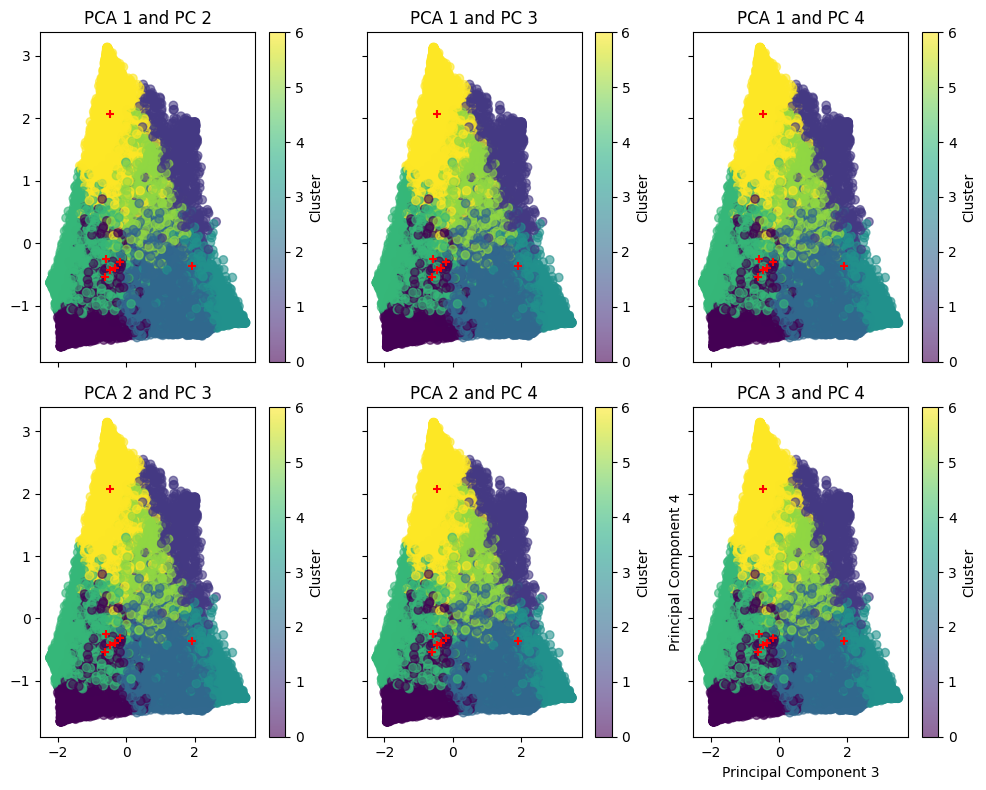

In [16]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_emotions_standardized)

COLUMNS = 3
ROWS = 2
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)
combinations = [[1, 2],[1, 3],[1, 4],[2, 3],[2, 4],[3, 4]]

for i, combination in enumerate(combinations):
    current_column = i % COLUMNS
    current_row = (i)//COLUMNS
    ax = axs[current_row, current_column]


    ax.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_, alpha=0.6)
    ax.set_title(f"PCA {combination[0]} and PC {combination[1]}")
    plt.xlabel(f'Principal Component {combination[0]}')
    plt.ylabel(f'Principal Component {combination[1]}')
    cbar = plt.colorbar(ax.collections[0], ax=ax, label='Cluster')
    # Plot the centroids
    for c in km.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

Even though, the clusters are mainly separated in the 2-dimensional PCA space (using the first 4 PC), the centroids of each clusters are mostly gathered around a point in space. 

### Visualizing with t-sne

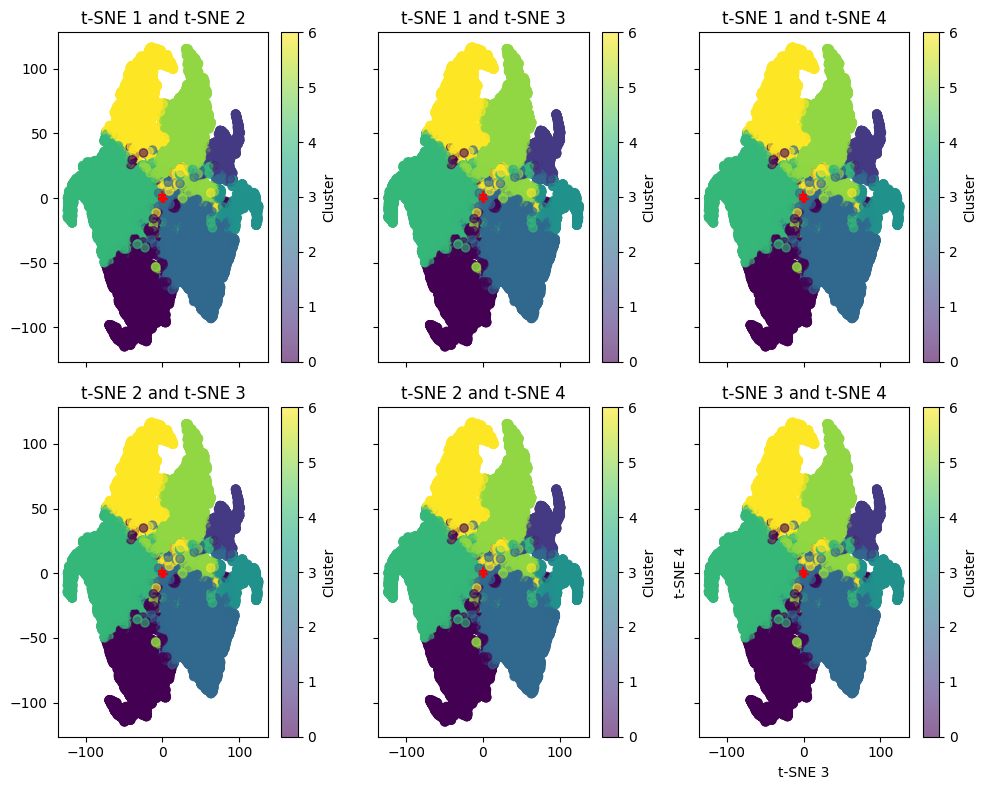

In [17]:
X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)

COLUMNS = 3
ROWS = 2
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)
combinations = [[1, 2],[1, 3],[1, 4],[2, 3],[2, 4],[3, 4]]

for i, combination in enumerate(combinations):
    current_column = i % COLUMNS
    current_row = (i)//COLUMNS
    ax = axs[current_row, current_column]


    ax.scatter(X_tsne[:,0], X_tsne[:,1], c=km.labels_, alpha=0.6)
    ax.set_title(f"t-SNE {combination[0]} and t-SNE {combination[1]}")
    plt.xlabel(f't-SNE {combination[0]}')
    plt.ylabel(f't-SNE {combination[1]}')
    cbar = plt.colorbar(ax.collections[0], ax=ax, label='Cluster')
    # Plot the centroids
    for c in km.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

### 3.1.4 Calculating cluster based consumer ratings

### Calculating ratings for each cluster

In [135]:
def clalculate_cluster_ratings(X, kmeans):

    km = kmeans
    
    len(df_emotions_standardized)
    df_emotions.head()
    
    df_cluster_catings = df_emotions.drop(columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"] )
    df_cluster_emotions = X.copy()
    
    df_cluster_emotions["cluster"] = km.labels_
    df_cluster_emotions = df_cluster_emotions.groupby("cluster").mean().reset_index()
    
    df_cluster_catings["cluster"] = km.labels_
    df_cluster_catings["mean_ratings"] = df.loc[df_cluster_catings.index,"mean_ratings"]
    #df_cluster_catings["std_dev_ratings"]  = df.loc[df_cluster_catings.index,"std_dev_ratings"]
    df_cluster_catings["count_ratings"]  = df.loc[df_cluster_catings.index,"count_ratings"]
    #print(f"Number of NaN values out of total:", df_cluster_catings["mean_ratings"].isna().sum(), "/", len(df_cluster_catings))
    
    column_std = []
    column_mean = []
    unique = []
    for cluster in (np.unique(km.labels_)):
        column_std.append(df_cluster_catings[df_cluster_catings["cluster"] == cluster]["mean_ratings"].std())
        column_mean.append(df_cluster_catings[df_cluster_catings["cluster"] == cluster]["mean_ratings"].mean())
        unique.append(cluster)

    
    df_cluster_catings_grouped = df_cluster_catings.groupby("cluster").mean()
    df_cluster_catings_grouped_counts = df_cluster_catings.groupby('cluster').agg({
        'mean_ratings': 'count', "cluster": "count"  # Counts non-NaN entries in the 'ratings' column for each cluster
    })
    #df_cluster_catings_grouped["std"] = column_std
    #df_cluster_catings_grouped["mean"] = column_mean
    df_cluster_catings_grouped["rating_movies_count"] = df_cluster_catings_grouped_counts["mean_ratings"]
    df_cluster_catings_grouped["movies_count"] = df_cluster_catings_grouped_counts["cluster"]

    #print(df_cluster_catings_grouped)


    return df_cluster_emotions, df_cluster_catings_grouped

catch =clalculate_cluster_ratings(df_emotions_standardized, km)

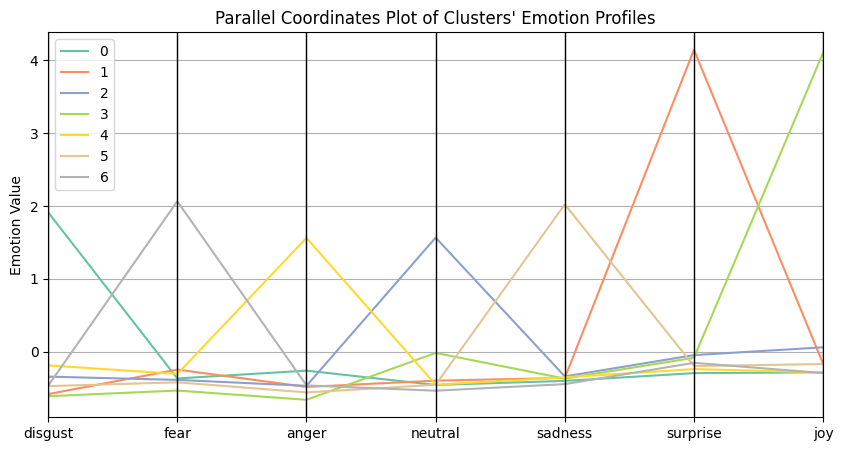

In [28]:
def plot_Parallel_Coordinates(df_cluster_emotions):
    plt.figure(figsize=(10, 5))
    parallel_coordinates(df_cluster_emotions, class_column='cluster', colormap=plt.get_cmap("Set2"))
    plt.title("Parallel Coordinates Plot of Clusters' Emotion Profiles")
    plt.ylabel("Emotion Value")
    plt.legend()
    plt.show()
plot_Parallel_Coordinates(df_cluster_emotions)

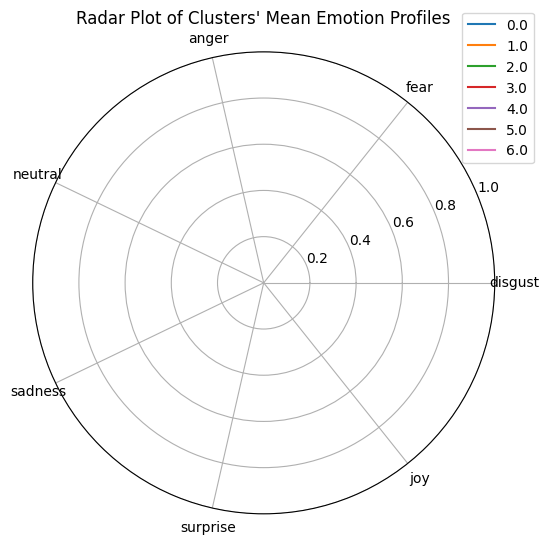

In [21]:
emotions_columns = [ "disgust","fear","anger","neutral","sadness", "surprise","joy"] 

# Number of variables
N = len(emotions_columns)

# Angles equally spaced around a circle
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster on the radar
for i, row in df_cluster_emotions.iterrows():
    values = row[emotions_columns].values
    # Repeat the first value at the end to close the polygon
    values = np.concatenate([values, [values[0]]])
    # Also repeat the first angle
    angles_all = np.concatenate([angles, [angles[0]]])
    ax.plot(angles_all, values, label=row['cluster'])
    ax.fill(angles_all, values, alpha=0.1)  # fill area

# Add emotion labels at angles
ax.set_xticks(angles)
ax.set_xticklabels(emotions_columns)

# Set radial limits (optional)
ax.set_ylim(0, 1) # Adjust depending on your data range

ax.set_title("Radar Plot of Clusters' Mean Emotion Profiles")
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

### K-means with Raw Emotion Data (unstandardized)

Best inertia: 2503.015216289512
Number of NaN values out of total: 24545 / 33684
Cluster Ratings          mean_ratings  std_dev_ratings  count_ratings       std      mean
cluster                                                                  
0            3.011892         0.946169      86.604611  0.859653  3.011892
1            3.156403         0.941831     111.884298  0.798542  3.156403
2            3.074431         0.987298      68.267544  0.836518  3.074431
3            2.939662         0.961237     136.145963  0.829792  2.939662
4            3.061479         0.954928     178.528281  0.774520  3.061479
5            3.080380         0.954659     201.023800  0.760542  3.080380
6            2.984835         0.979874      81.660833  0.811494  2.984835
Cluster Mean Emotions    cluster   disgust      fear     anger   neutral   sadness  surprise  \
0        0  0.629082  0.054214  0.133777  0.104885  0.057833  0.010188   
1        1  0.064614  0.042272  0.057356  0.106014  0.680828  0.024

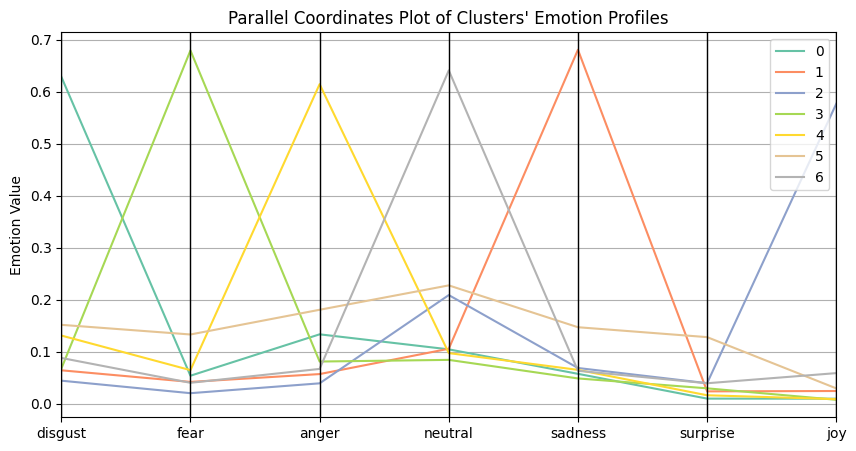

In [36]:
kmeans_raw = find_best_init(df_emotions)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions, kmeans_raw)
plot_Parallel_Coordinates(df_cluster_emotions)

### Kmeans with cosine similarity raw emotions

Best inertia: 4702.391540661267
Number of NaN values out of total: 24545 / 33684
Cluster Ratings          mean_ratings  std_dev_ratings  count_ratings       std      mean
cluster                                                                  
0            2.986457         0.970178     113.757720  0.804659  2.986457
1            3.163481         0.942283     139.501406  0.773914  3.163481
2            3.041648         0.937812      94.128988  0.849732  3.041648
3            2.971245         0.965888     165.094027  0.814242  2.971245
4            3.059619         0.955367     189.726908  0.768883  3.059619
5            3.071285         1.012950      79.976471  0.809660  3.071285
6            3.086701         0.961134     149.927614  0.775537  3.086701
Cluster Mean Emotions    cluster   disgust      fear     anger   neutral   sadness  surprise  \
0        0  0.102773  0.053950  0.090642  0.580298  0.077798  0.041139   
1        1  0.078475  0.050721  0.075387  0.123142  0.618938  0.026

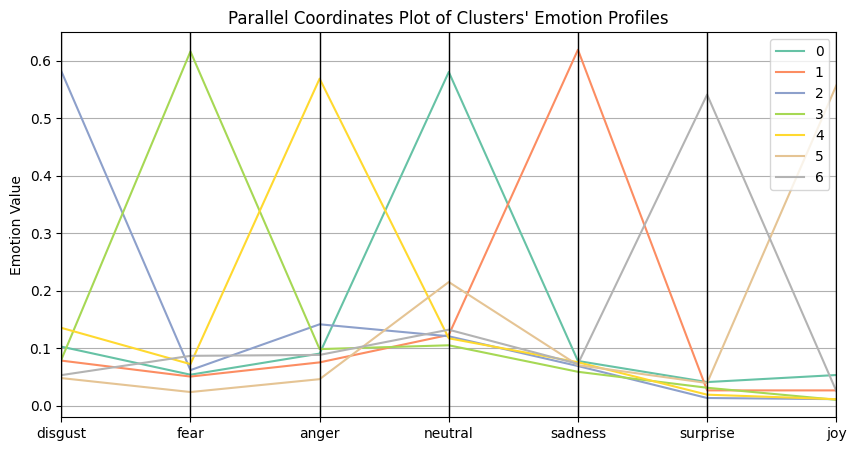

In [41]:
normalized_data = normalize(df_emotions, norm='l2')
kmeans_cosine = find_best_init(normalized_data)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions, kmeans_cosine)
plot_Parallel_Coordinates(df_cluster_emotions)

### Kmeans with cosine similarity standardized emotions

Best inertia: 7622.551336975673
Number of NaN values out of total: 24545 / 33684
Cluster Ratings          mean_ratings  std_dev_ratings  count_ratings       std      mean
cluster                                                                  
0            2.985064         0.969074     104.115143  0.796080  2.985064
1            3.041776         0.942958      95.446102  0.845934  3.041776
2            3.160937         0.941918     141.748031  0.776902  3.160937
3            3.058159         0.951302     180.107754  0.774108  3.058159
4            3.058737         0.963840     183.248097  0.757141  3.058737
5            2.969760         0.960606     165.453365  0.825422  2.969760
6            3.077663         1.007079     126.543260  0.798653  3.077663
Cluster Mean Emotions    cluster   disgust      fear     anger   neutral   sadness  surprise  \
0        0 -0.348096 -0.417166 -0.464225  1.742269 -0.380892 -0.116058   
1        1  1.883396 -0.378126 -0.227787 -0.436072 -0.401252 -0.307

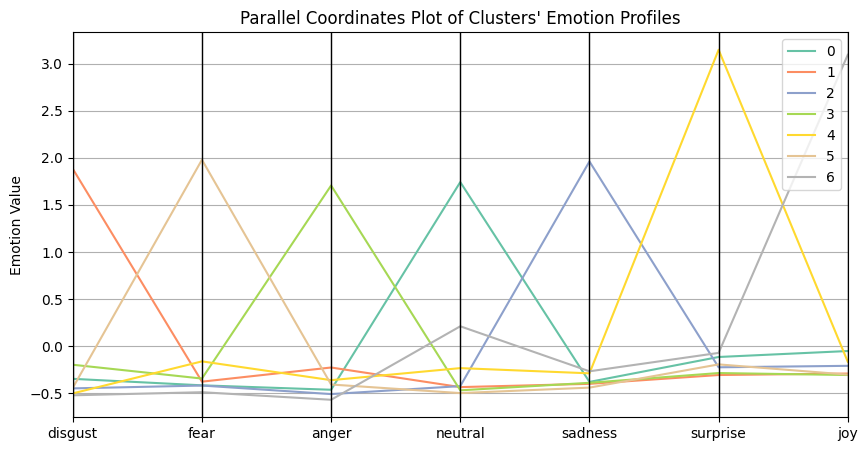

In [42]:
normalized_data = normalize(df_emotions_standardized, norm='l2')
kmeans_cosine = find_best_init(normalized_data)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, kmeans_cosine)
plot_Parallel_Coordinates(df_cluster_emotions)

In [52]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
labels = dbscan_standardized.labels_

print("number of clusters", len(np.unique(labels)))

# Calculate Silhouette Score
# Filter out noise points
valid_clusters = df_emotions_standardized[labels != -1]
valid_labels = labels[labels != -1]

if len(np.unique(valid_labels)) > 1:  # Need at least 2 clusters to calculate
    silhouette_avg = silhouette_score(valid_clusters, valid_labels)
    print("Silhouette Score: ", silhouette_avg)
else:
    print("Not enough clusters to calculate the silhouette score.")



number of clusters 60
Silhouette Score:  -0.4825812756805062


In [107]:
# Calculate average distance within each cluster
total = 0.0
for label in np.unique(labels):
    if label != -1:  # Ignore noise
        members = df_emotions_standardized[labels == label]
        centroid = members.mean(axis=0)
        distances = np.sqrt(((members - centroid) ** 2).sum(axis=1))
        avg_distance = distances.mean()
        print(f"Average distance for cluster {label}: {avg_distance}")
        total += avg_distance

print ("total within cluster distance", total)

def calculate_sum_of_within_cluster_distances(X, dbscan):
    total = 0.0
    for label in np.unique(dbscan.labels_):
        if label != -1:  # Ignore noise
            members = df_emotions_standardized[dbscan.labels_ == label]
            centroid = members.mean(axis=0)
            distances = np.sqrt(((members - centroid) ** 2).sum(axis=1))
            avg_distance = distances.mean()
            total += avg_distance
    
    print ("total within cluster distance", total)
    return total
    


Average distance for cluster 0: 1.9290293593035126
Average distance for cluster 1: 0.43670611709749985
Average distance for cluster 2: 0.255177466784419
Average distance for cluster 3: 0.4647355542939673
Average distance for cluster 4: 0.597408749428863
Average distance for cluster 5: 0.10977766384108731
Average distance for cluster 6: 0.08984422791795067
Average distance for cluster 7: 0.1389802306775787
Average distance for cluster 8: 0.2570292662001953
Average distance for cluster 9: 0.0844283968250386
Average distance for cluster 10: 0.11495557178248232
Average distance for cluster 11: 0.10231087454996579
Average distance for cluster 12: 0.13833014007948777
Average distance for cluster 13: 0.26872374583983893
Average distance for cluster 14: 0.1196275613400203
Average distance for cluster 15: 0.21979895425079635
Average distance for cluster 16: 0.08974652952877278
Average distance for cluster 17: 0.5074284970187387
Average distance for cluster 18: 0.11016354696356138
Average distan

In [141]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
print(cluster_ratings.sort_values(by='movies_count', ascending=False))

         mean_ratings  count_ratings  rating_movies_count  movies_count
cluster                                                                
 0           3.044204     142.742212                 8988         33278
-1           3.167149     233.364865                   74           223
 6           3.238191      41.000000                   11            19
 12          2.549493      20.333333                    6            14
 4           2.959430      30.500000                    2             8
 9           3.417357     350.666667                    3             6
 11          2.847222      22.500000                    2             6
 26          3.000000       8.500000                    2             4
 36               NaN            NaN                    0             4
 28          2.279758     262.666667                    3             4
 25               NaN            NaN                    0             4
 33          2.423851      87.500000                    2       

In [142]:
dbscan = DBSCAN(eps=0.45, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
print(cluster_ratings.sort_values(by='movies_count', ascending=False))

         mean_ratings  count_ratings  rating_movies_count  movies_count
cluster                                                                
 0           3.044315     140.736083                 8874         32908
-1           3.064384     265.198630                  146           427
 10          3.341339      36.777778                    9            16
 19          2.549493      20.333333                    6            13
 32          4.216712     184.500000                    2            10
...               ...            ...                  ...           ...
 48          2.595745      94.000000                    1             2
 46          4.054669     832.000000                    2             2
 45          3.916667       6.000000                    1             2
 44          3.492424      47.500000                    2             2
 116              NaN            NaN                    0             2

[118 rows x 4 columns]


In [143]:
dbscan = DBSCAN(eps=0.55, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
print(cluster_ratings.sort_values(by='movies_count', ascending=False))

         mean_ratings  count_ratings  rating_movies_count  movies_count
cluster                                                                
 0           3.043475     143.012594                 9052         33434
-1           3.090417     252.590909                   44           129
 4           3.195305      39.384615                   13            29
 8           2.549493      20.333333                    6            14
 9                NaN            NaN                    0             4
 15               NaN            NaN                    0             4
 14          3.651282     112.500000                    2             4
 26               NaN            NaN                    0             3
 27          3.144754      84.000000                    2             3
 29          2.783217     286.000000                    1             3
 23          3.000000       1.000000                    2             3
 6           3.121566      93.000000                    3       

In [144]:
dbscan = DBSCAN(eps=0.4, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
print(cluster_ratings.sort_values(by='movies_count', ascending=False))

         mean_ratings  count_ratings  rating_movies_count  movies_count
cluster                                                                
 0           3.041468     139.921439                 8592         32020
-1           3.081440     247.866920                  263           826
 6           3.196831     155.000000                   25            68
 132         2.328984      43.250000                    4            12
 62          2.661316     824.000000                    3            12
...               ...            ...                  ...           ...
 118              NaN            NaN                    0             2
 120              NaN            NaN                    0             2
 121              NaN            NaN                    0             2
 123              NaN            NaN                    0             2
 258         2.664019     100.500000                    2             2

[260 rows x 4 columns]


In [145]:
dbscan = DBSCAN(eps=0.35, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
print(cluster_ratings.sort_values(by='movies_count', ascending=False))

         mean_ratings  count_ratings  rating_movies_count  movies_count
cluster                                                                
 0           3.043172     136.426932                 8102         30451
-1           3.080407     225.982692                  520          1595
 16          2.885298     394.588235                   34           110
 5           3.007813     309.076923                   13            39
 238         3.470803      88.888889                    9            25
...               ...            ...                  ...           ...
 223         3.500000       1.000000                    1             2
 222         3.500000       3.000000                    1             2
 221              NaN            NaN                    0             2
 220              NaN            NaN                    0             2
 482         3.694444      18.000000                    1             2

[484 rows x 4 columns]


In [146]:
dbscan = DBSCAN(eps=0.30, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
print(cluster_ratings.sort_values(by='movies_count', ascending=False))

         mean_ratings  count_ratings  rating_movies_count  movies_count
cluster                                                                
 0           3.045978     137.006560                 7469         28214
-1           3.034606     199.319825                  913          2907
 2           2.924349      96.731343                   67           307
 14          2.848260     108.190476                   21            82
 47          3.342361      43.392857                   28            77
...               ...            ...                  ...           ...
 311         3.500000       1.000000                    1             2
 310              NaN            NaN                    0             2
 309         3.368421      19.000000                    1             2
 308              NaN            NaN                    0             2
 696         3.694444      18.000000                    1             2

[698 rows x 4 columns]


In [ ]:
plot_Parallel_Coordinates(df_cluster_emotions)

### Try different DBSCAN configurations

Metrics:
1) Sum of withing cluster distances
2) Number of clusters
3) Number of clusters with number of movies >5

KeyboardInterrupt: 

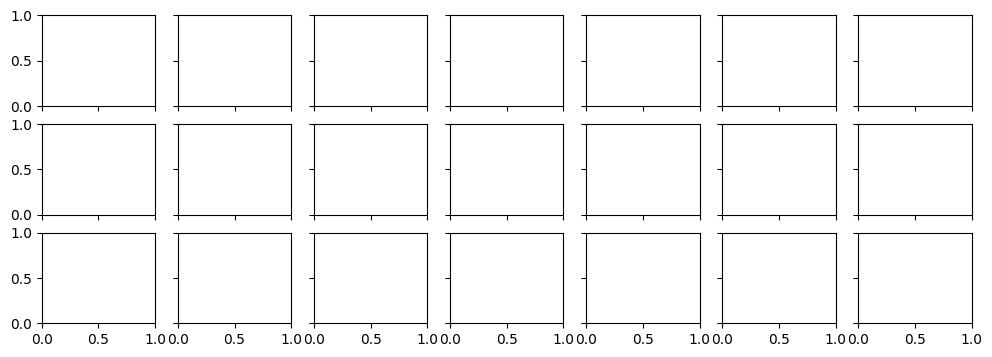

In [119]:
# Create a list of eps
eps_list = np.linspace(0.05, 1, 20)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(df_emotions_standardized)

    X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)
    ax.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()

In [120]:
for i in range(0, len(eps_list)):
    print(eps_list[i])
    dbscan = DBSCAN(eps=eps_list[i], min_samples=2)
    dbscan_standardized = dbscan.fit(df_emotions_standardized)
    valid_clusters = df_emotions_standardized[labels != -1]
    valid_labels = labels[labels != -1]
    sum_distance =  calculate_sum_of_within_cluster_distances(df_emotions_standardized, dbscan_standardized)
    print ("Sum of within cluster distances",sum_distance)
    df_cluster_emotions, cluster_ratings = clalculate_cluster_ratings(df_emotions_standardized, dbscan_standardized)
    print("Number of clusters", len(cluster_ratings))
    print("Number of clusters with number of movies >5", (cluster_ratings['movies_count'] > 5).sum())
    
    

0.05
total within cluster distance 14.937939137231998
Sum of within cluster distances 14.937939137231998
Number of clusters 634
Number of clusters with number of movies >5 39
0.1
total within cluster distance 82.62535427174682
Sum of within cluster distances 82.62535427174682
Number of clusters 1690
Number of clusters with number of movies >5 98
0.15
total within cluster distance 159.80856007705142
Sum of within cluster distances 159.80856007705142
Number of clusters 2041
Number of clusters with number of movies >5 188
0.2
total within cluster distance 156.53772436903225
Sum of within cluster distances 156.53772436903225
Number of clusters 1557
Number of clusters with number of movies >5 113
0.25
total within cluster distance 126.10675364789395
Sum of within cluster distances 126.10675364789395
Number of clusters 1001
Number of clusters with number of movies >5 83
0.3
total within cluster distance 107.70995212751052
Sum of within cluster distances 107.70995212751052
Number of clusters 

### Visualize DBSCAN clusters with PCA 

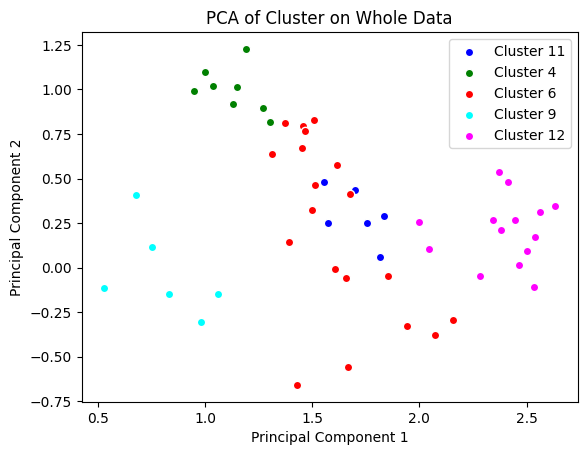

In [134]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan = dbscan.fit(df_emotions_standardized)
labels = dbscan.labels_

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_emotions_standardized)

# Filter results for a specific cluster for visualization
cluster_of_interest = 1
filtered_indices = (labels == cluster_of_interest) | (labels == 2) | (labels == 3) | (labels == 4) | (labels == 5)
filtered_pca_result = pca_result[filtered_indices]

colors = ['blue', 'green', 'red', 'cyan', 'magenta']
clusters_to_visualize = [11,4,6,9,12]

for i,cluster in enumerate(clusters_to_visualize):
    # Filter points belonging to the current cluster
    idx = labels == cluster
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], c=colors[i], label=f'Cluster {cluster}', edgecolors='w')

plt.title('PCA of Cluster on Whole Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Visualize DBSCAN clusters with t-sne

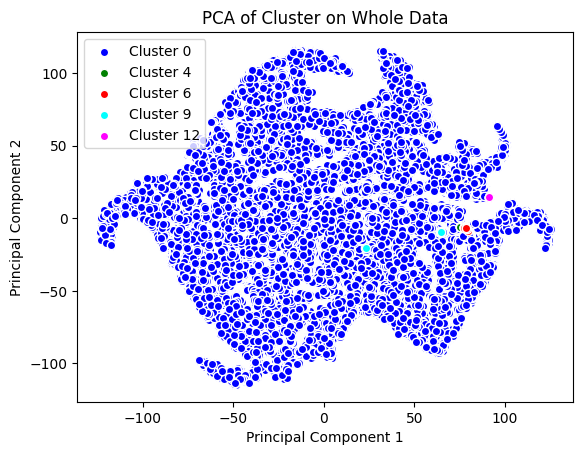

In [133]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan = dbscan.fit(df_emotions_standardized)
labels = dbscan.labels_

X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)


colors = ['blue', 'green', 'red', 'cyan', 'magenta']
clusters_to_visualize = [0,4,6,9,12]

for i,cluster in enumerate(clusters_to_visualize):
    # Filter points belonging to the current cluster
    idx = labels == cluster
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=f'Cluster {cluster}', edgecolors='w')

plt.title('PCA of Cluster on Whole Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## 3.2 Visualizing clusters

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_standardized)

# Plot the PCA components
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Movies clustering visualized in PCA space')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=7, random_state=10).fit_predict(df_emotions_standardized)

X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)
# Plot the data reduced in 2d space with t-SNE
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=kmeans, alpha=0.6)
plt.title("t-SNE")
for c in kmean.cluster_centers_:
        plt.scatter(c[0], c[1], marker="+", color="red")

In [ ]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(df_emotions_standardized)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(x_standardized)
    
    ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()

COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(df_emotions_standardized)

    X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)
    X_pca = pca.fit_transform(x_standardized)
    
    ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,0], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()


In [ ]:
df.head()